In [1]:
%load_ext line_profiler
import matplotlib.pyplot as plt
from qubitsim import State
from qubitsim import Gate


## Initialise the $\ket{000}$ state

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


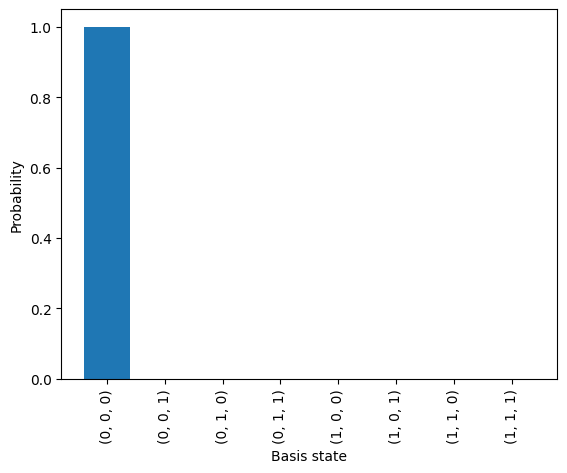

In [2]:
state = State(3)
print(state.basis)
state.plot_state()



## Apply some some gates
(I always initialise the $\ket{000}$ state)

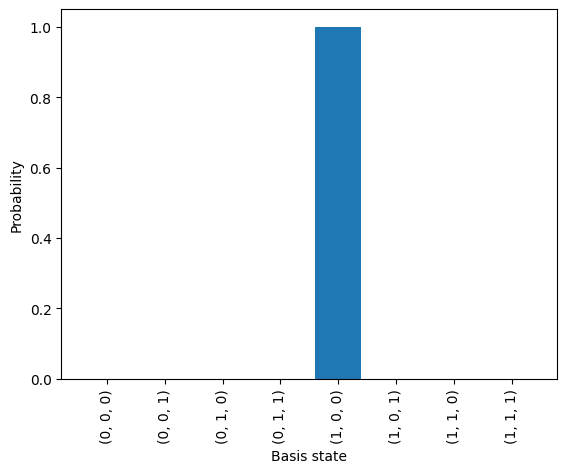

In [12]:
## Apply an X gate 
num = 3
state = State(num)
X = Gate().X
state.apply_single_qubit_gate(X, 0)
state.plot_state()


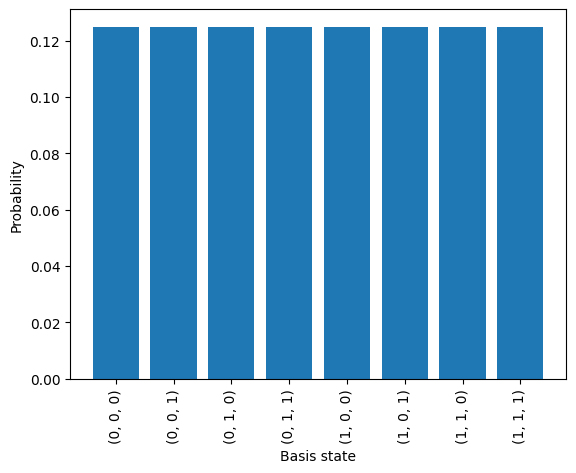

In [14]:
## Apply Hadamard gate on all qubits

num = 3

state = State(num, )
H = Gate().H

[state.apply_single_qubit_gate(H, i) for i in range(0,num)]

state.apply_single_qubit_gate(Gate().Y, 2)
state.apply_cnot_qubit_gate(0,2)

state.plot_state()


## Initialise state $\ket{100}$

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


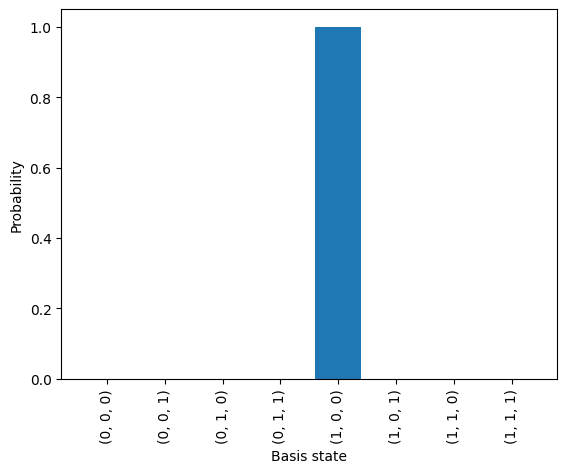

In [5]:
state = State(3, 4) #Initialise state in #100 
print(state.basis)
state.plot_state()

## Comparing the performance of `np.kron` and `np.einsum` for creating the multiqubit gate tensor

In [11]:
times_kron = np.zeros(13)
times_einsum = np.zeros(13)
for i, num in enumerate(range(1,13+1)):
    print(f'nqubits = {num}')
    state = State(num)
    var1 = %timeit -o state.apply_single_qubit_gate(H, 0)
    times_kron[i] = var1.average
    state = State(num)
    var2 = %timeit -o state.apply_single_qubit_gate(H, 0,'einsum')
    times_einsum[i] = var2.average
    

nqubits = 1
1.42 μs ± 18.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
2.73 μs ± 45.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 2
9.44 μs ± 70.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
3.8 μs ± 71 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 3
17.5 μs ± 222 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
4.49 μs ± 39.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 4
26.3 μs ± 120 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
7.09 μs ± 42.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 5
37.7 μs ± 320 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
16.7 μs ± 305 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 6
148 μs ± 38.2 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
108 μs ± 1.92 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
nqubits = 7
212 μs ± 10.7 μ

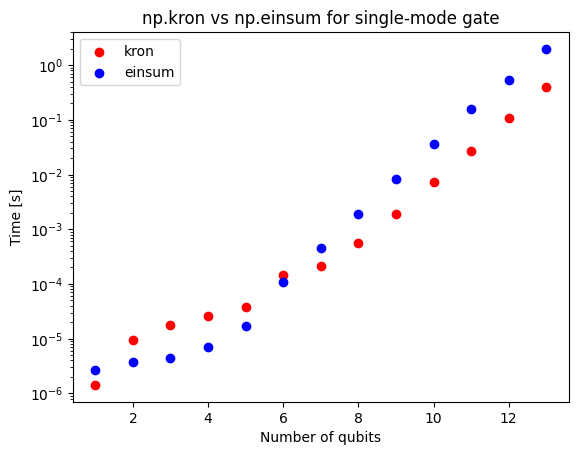

In [12]:
plt.scatter(range(1,14), times_kron, color = 'r', label = 'kron')
plt.scatter(range(1,14), times_einsum, color ='b',label = 'einsum')
plt.yscale('log')
plt.xlabel('Number of qubits')
plt.ylabel('Time [s]')
plt.legend()
plt.title('np.kron vs np.einsum for single-mode gate')
plt.show()

In [9]:
times_kron = np.zeros(13)
times_einsum = np.zeros(13)
for i, num in enumerate(range(1,13+1)):
    print(f'nqubits = {num}')
    state = State(num)
    
    var1 = %timeit -o state.apply_cnot_qubit_gate(0,1)
    times_kron[i] = var1.average
    state = State(num)
    var2 = %timeit -o state.apply_cnot_qubit_gate(0,1,'einsum')
    times_einsum[i] = var2.average

nqubits = 1
3.9 μs ± 15.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
6.04 μs ± 63.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 2
21.2 μs ± 374 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
7.9 μs ± 51.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 3
36.6 μs ± 809 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
9.32 μs ± 95.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 4


KeyboardInterrupt: 

In [ ]:
plt.scatter(range(1,14), times_kron, color = 'r', label = 'kron')
plt.scatter(range(1,14), times_einsum, color ='b',label = 'einsum')
plt.yscale('log')
plt.xlabel('Number of qubits')
plt.ylabel('Time [s]')
plt.legend()
plt.title('np.kron vs np.einsum for cnot gate')
plt.show()

In [6]:
num = 3
state = State(num)
%lprun -f state.apply_single_qubit_gate state.apply_single_qubit_gate(H, 0, method = 'kron')

Timer unit: 1e-09 s

Total time: 0.00034 s
File: /Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/qcircuit/qubitsim.py
Function: apply_single_qubit_gate at line 120

Line #      Hits         Time  Per Hit   % Time  Line Contents
   120                                               def apply_single_qubit_gate(self, gate, k :int, method = 'kron'):
   121                                                   
   122         1     300000.0 300000.0     88.2          multigate = Multi_gate(gate, k, self.num_qubits, method)
   123                                                       
   124         1          0.0      0.0      0.0          if method == 'einsum':
   125                                                       multigate = multigate.reshape((self.tdim_flat, self.tdim_flat))
   126                                                   
   127         1      40000.0  40000.0     11.8          self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat)).

In [7]:
num = 3
state = State(num)
%lprun -f state.apply_single_qubit_gate state.apply_single_qubit_gate(H, 0, method = 'einsum')

Timer unit: 1e-09 s

Total time: 0.000234 s
File: /Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/qcircuit/qubitsim.py
Function: apply_single_qubit_gate at line 120

Line #      Hits         Time  Per Hit   % Time  Line Contents
   120                                               def apply_single_qubit_gate(self, gate, k :int, method = 'kron'):
   121                                                   
   122         1     174000.0 174000.0     74.4          multigate = Multi_gate(gate, k, self.num_qubits, method)
   123                                                       
   124         1       1000.0   1000.0      0.4          if method == 'einsum':
   125         1       5000.0   5000.0      2.1              multigate = multigate.reshape((self.tdim_flat, self.tdim_flat))
   126                                                   
   127         1      54000.0  54000.0     23.1          self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat))

## Profiling `Multi_CNOT`

In [11]:
from qubitsim import Multi_CNOT
%prun Multi_CNOT(0, 2, 10)

         1339 function calls in 0.032 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       18    0.028    0.002    0.029    0.002 shape_base.py:1067(kron)
        1    0.002    0.002    0.032    0.032 qubitsim.py:52(Multi_CNOT)
       72    0.000    0.000    0.001    0.000 shape_base.py:512(expand_dims)
       72    0.000    0.000    0.000    0.000 numeric.py:1330(normalize_axis_tuple)
       90    0.000    0.000    0.000    0.000 {method 'reshape' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.032    0.032 <string>:1(<module>)
        2    0.000    0.000    0.030    0.015 {built-in method _functools.reduce}
       72    0.000    0.000    0.000    0.000 shape_base.py:600(<listcomp>)
       17    0.000    0.000    0.000    0.000 twodim_base.py:158(eye)
       72    0.000    0.000    0.000    0.000 numeric.py:1380(<listcomp>)
        1    0.000    0.000    0.032    0.032 {built-in method builtins.exec}
       

In [9]:
%prun Multi_CNOT(0, 2, 10, 'einsum')

         120 function calls in 0.090 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.089    0.044    0.089    0.044 {built-in method numpy.core._multiarray_umath.c_einsum}
        1    0.001    0.001    0.090    0.090 qubitsim.py:52(Multi_CNOT)
        1    0.000    0.000    0.090    0.090 <string>:1(<module>)
       17    0.000    0.000    0.000    0.000 twodim_base.py:158(eye)
        1    0.000    0.000    0.090    0.090 {built-in method builtins.exec}
        3    0.000    0.000    0.000    0.000 {built-in method numpy.array}
       17    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        2    0.000    0.000    0.089    0.044 einsumfunc.py:1009(einsum)
        1    0.000    0.000    0.000    0.000 qubitsim.py:62(<listcomp>)
       26    0.000    0.000    0.000    0.000 einsumfunc.py:1001(_einsum_dispatcher)
        1    0.000    0.000    0.000    0.000 qubitsim.py:63(<listcomp>)
      

## Measure a qubit

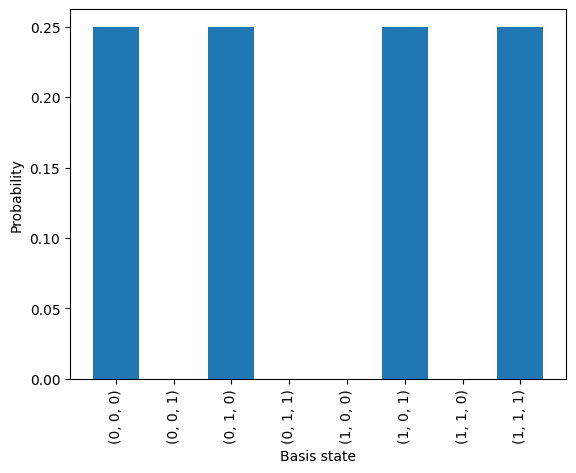

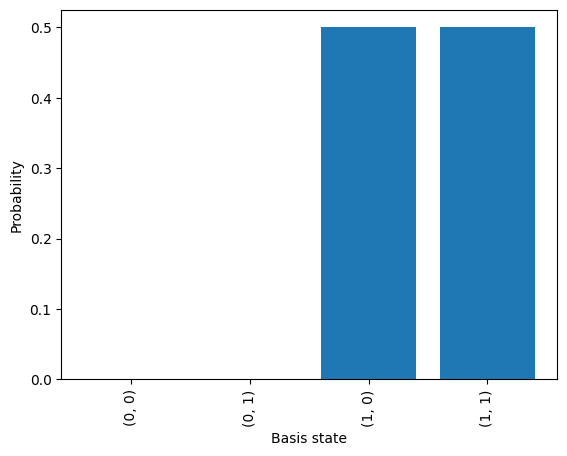

In [10]:
#Initial state
state = State(3)
state.apply_single_qubit_gate(H, 0)
state.apply_single_qubit_gate(H, 1)
state.apply_cnot_qubit_gate(0,2)
state.plot_state()
plt.show()


#Measure mode 0 to be 1
state.conditional_measurement(2,1)
state.plot_state()
